## Capstone Project: InsideAirbnb
------------------------------------------------------------------------------------------------------------------------
## Part 3. Modelling

## Table of Contents
- [Importing the libraries](#Importing-the-libraries)
- [Importing the datasets](#Importing-the-datasets)
- [Split data into Train Test Split](#Split-data-into-Train-Test-Split)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

### Importing the libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
from math import sqrt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

pd.pandas.set_option('display.max_columns', None)

In [18]:
listings = pd.read_csv('./data/user_listings_final.csv')

In [19]:
listings.head()

,price,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathroom_qty,bathroom_type,mrtDisp,nearestMRT,cityDisp
0,80.0,1.33432,103.78521,Apartment,Private room,2,1.0,1.0,1,baths,0.272114,King Albert Park,9.168433
1,145.0,1.34537,103.95887,Home,Private room,6,2.0,3.0,1,private,0.456774,Upper Changi,13.932315
2,184.0,1.34490,103.95979,Home,Private room,4,3.0,5.0,3,baths,0.353956,Upper Changi,13.995598
3,79.0,1.31142,103.83924,Apartment,Private room,2,1.0,1.0,1,shared,0.300294,Newton,3.347789
4,49.0,1.28828,103.81020,Apartment,Private room,1,1.0,1.0,0,baths,0.748483,Redhill,4.458968


### Importing the datasets

In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092 entries, 0 to 3091
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          3092 non-null   float64
 1   latitude       3092 non-null   float64
 2   longitude      3092 non-null   float64
 3   property_type  3092 non-null   object 
 4   room_type      3092 non-null   object 
 5   accommodates   3092 non-null   int64  
 6   bedrooms       3092 non-null   float64
 7   beds           3092 non-null   float64
 8   bathroom_qty   3092 non-null   int64  
 9   bathroom_type  3092 non-null   object 
 10  mrtDisp        3092 non-null   float64
 11  nearestMRT     3092 non-null   object 
 12  cityDisp       3092 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 314.2+ KB


In [42]:
listings.head()

,price,latitude,longitude,accommodates,bedrooms,beds,bathroom_qty,mrtDisp,cityDisp,property_type_Apartment,property_type_Condominium,property_type_Home,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Others,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_baths,bathroom_type_private,bathroom_type_shared,nearestMRT_Aljunied,nearestMRT_Ang Mo Kio,nearestMRT_Bartley,nearestMRT_Bayfront,nearestMRT_Beauty World,nearestMRT_Bedok,nearestMRT_Bedok North,nearestMRT_Bencoolen,nearestMRT_Bendemeer,nearestMRT_Bishan,nearestMRT_Boon Keng,nearestMRT_Boon Lay,nearestMRT_Botanic Gardens,nearestMRT_Braddell,nearestMRT_Bras Basah,nearestMRT_Buangkok,nearestMRT_Bugis,nearestMRT_Bukit Batok,nearestMRT_Bukit Gombak,nearestMRT_Bukit Panjang,nearestMRT_Buona Vista,nearestMRT_Caldecott,nearestMRT_Cashew,nearestMRT_Chinatown,nearestMRT_Chinese Garden,nearestMRT_Choa Chu Kang,nearestMRT_City Hall,nearestMRT_Clarke Quay,nearestMRT_Clementi,nearestMRT_Commonwealth,nearestMRT_Dakota,nearestMRT_Dhoby Ghaut,nearestMRT_Dover,nearestMRT_Downtown,nearestMRT_Esplanade,nearestMRT_Eunos,nearestMRT_Expo,nearestMRT_Farrer Park,nearestMRT_Farrer Road,nearestMRT_Fort Canning,nearestMRT_Geylang Bahru,nearestMRT_HarbourFront,nearestMRT_Haw Par Villa,nearestMRT_Hillview,nearestMRT_Holland Village,nearestMRT_Hougang,nearestMRT_Jalan Besar,nearestMRT_Joo Koon,nearestMRT_Jurong East,nearestMRT_Kaki Bukit,nearestMRT_Kallang,nearestMRT_Kembangan,nearestMRT_Kent Ridge,nearestMRT_Khatib,nearestMRT_King Albert Park,nearestMRT_Kovan,nearestMRT_Labrador Park,nearestMRT_Lakeside,nearestMRT_Lavender,nearestMRT_Little India,nearestMRT_Lorong Chuan,nearestMRT_MacPherson,nearestMRT_Marina Bay,nearestMRT_Marsiling,nearestMRT_Marymount,nearestMRT_Mattar,nearestMRT_Mountbatten,nearestMRT_Newton,nearestMRT_Nicoll Highway,nearestMRT_Novena,nearestMRT_Orchard,nearestMRT_Outram Park,nearestMRT_Pasir Panjang,nearestMRT_Pasir Ris,nearestMRT_Paya Lebar,nearestMRT_Pioneer,nearestMRT_Potong Pasir,nearestMRT_Promenade,nearestMRT_Punggol,nearestMRT_Queenstown,nearestMRT_Raffles Place,nearestMRT_Redhill,nearestMRT_Rochor,nearestMRT_Sembawang,nearestMRT_Sengkang,nearestMRT_Serangoon,nearestMRT_Simei,nearestMRT_Sixth Avenue,nearestMRT_Somerset,nearestMRT_Stadium,nearestMRT_Stevens,nearestMRT_Tampines,nearestMRT_Tampines East,nearestMRT_Tampines West,nearestMRT_Tan Kah Kee,nearestMRT_Tanah Merah,nearestMRT_Tanjong Pagar,nearestMRT_Telok Ayer,nearestMRT_Telok Blangah,nearestMRT_Tiong Bahru,nearestMRT_Toa Payoh,nearestMRT_Ubi,nearestMRT_Upper Changi,nearestMRT_Woodlands,nearestMRT_Woodleigh,nearestMRT_Yew Tee,nearestMRT_Yio Chu Kang,nearestMRT_Yishun,nearestMRT_one-north
0,4.382027,1.33432,103.78521,2,1.0,1.0,1,0.272114,9.168433,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.976734,1.34537,103.95887,6,2.0,3.0,1,0.456774,13.932315,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5.214936,1.34490,103.95979,4,3.0,5.0,3,0.353956,13.995598,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4.369448,1.31142,103.83924,2,1.0,1.0,1,0.300294,3.347789,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.891820,1.28828,103.81020,1,1.0,1.0,0,0.748483,4.4

#### Categorical Features

#### Dummy encoding of categorical features

In [21]:
# The following columns are categorical and we will use create dummies to encode them
categorical_features = ['property_type', 'room_type', 'bathroom_type','nearestMRT']
# One hot encoding
listings = pd.get_dummies(listings, columns=categorical_features)

### Log transformation of Target variable

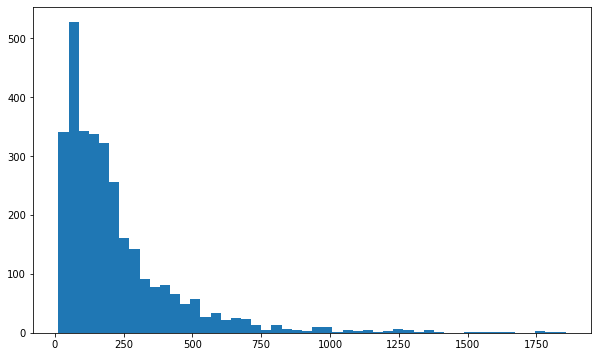

In [22]:
# Plot histogram of target variable
plt.figure(figsize=(10,6))
plt.hist(listings['price'], bins=50)
plt.show()

In [23]:
# # Log the price variable
listings['price'] = np.log(listings['price'])

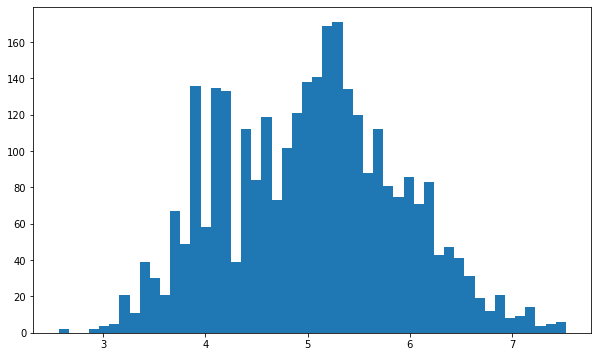

In [24]:
# Plot histogram of target variable
plt.figure(figsize=(10,6))
plt.hist(listings['price'], bins=50)
plt.show()

### Split the data into Train and Test sets

In [25]:
# Select the features and target variable
X = listings.drop('price', axis=1)
y = listings['price']

In [26]:
# Perform Train, Test, Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# Check the shape of our dataframe
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (2164, 131)
The shape of X_test is (928, 131)
The shape of y_train is (2164,)
The shape of y_test is (928,)


### Min Max Scaling ###

In [28]:
# Define numerical features 
numerical_features = X.select_dtypes(include = ['float64', 'int64']).columns

In [29]:
listings.head()

,price,latitude,longitude,accommodates,bedrooms,beds,bathroom_qty,mrtDisp,cityDisp,property_type_Apartment,property_type_Condominium,property_type_Home,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Others,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_baths,bathroom_type_private,bathroom_type_shared,nearestMRT_Aljunied,nearestMRT_Ang Mo Kio,nearestMRT_Bartley,nearestMRT_Bayfront,nearestMRT_Beauty World,nearestMRT_Bedok,nearestMRT_Bedok North,nearestMRT_Bencoolen,nearestMRT_Bendemeer,nearestMRT_Bishan,nearestMRT_Boon Keng,nearestMRT_Boon Lay,nearestMRT_Botanic Gardens,nearestMRT_Braddell,nearestMRT_Bras Basah,nearestMRT_Buangkok,nearestMRT_Bugis,nearestMRT_Bukit Batok,nearestMRT_Bukit Gombak,nearestMRT_Bukit Panjang,nearestMRT_Buona Vista,nearestMRT_Caldecott,nearestMRT_Cashew,nearestMRT_Chinatown,nearestMRT_Chinese Garden,nearestMRT_Choa Chu Kang,nearestMRT_City Hall,nearestMRT_Clarke Quay,nearestMRT_Clementi,nearestMRT_Commonwealth,nearestMRT_Dakota,nearestMRT_Dhoby Ghaut,nearestMRT_Dover,nearestMRT_Downtown,nearestMRT_Esplanade,nearestMRT_Eunos,nearestMRT_Expo,nearestMRT_Farrer Park,nearestMRT_Farrer Road,nearestMRT_Fort Canning,nearestMRT_Geylang Bahru,nearestMRT_HarbourFront,nearestMRT_Haw Par Villa,nearestMRT_Hillview,nearestMRT_Holland Village,nearestMRT_Hougang,nearestMRT_Jalan Besar,nearestMRT_Joo Koon,nearestMRT_Jurong East,nearestMRT_Kaki Bukit,nearestMRT_Kallang,nearestMRT_Kembangan,nearestMRT_Kent Ridge,nearestMRT_Khatib,nearestMRT_King Albert Park,nearestMRT_Kovan,nearestMRT_Labrador Park,nearestMRT_Lakeside,nearestMRT_Lavender,nearestMRT_Little India,nearestMRT_Lorong Chuan,nearestMRT_MacPherson,nearestMRT_Marina Bay,nearestMRT_Marsiling,nearestMRT_Marymount,nearestMRT_Mattar,nearestMRT_Mountbatten,nearestMRT_Newton,nearestMRT_Nicoll Highway,nearestMRT_Novena,nearestMRT_Orchard,nearestMRT_Outram Park,nearestMRT_Pasir Panjang,nearestMRT_Pasir Ris,nearestMRT_Paya Lebar,nearestMRT_Pioneer,nearestMRT_Potong Pasir,nearestMRT_Promenade,nearestMRT_Punggol,nearestMRT_Queenstown,nearestMRT_Raffles Place,nearestMRT_Redhill,nearestMRT_Rochor,nearestMRT_Sembawang,nearestMRT_Sengkang,nearestMRT_Serangoon,nearestMRT_Simei,nearestMRT_Sixth Avenue,nearestMRT_Somerset,nearestMRT_Stadium,nearestMRT_Stevens,nearestMRT_Tampines,nearestMRT_Tampines East,nearestMRT_Tampines West,nearestMRT_Tan Kah Kee,nearestMRT_Tanah Merah,nearestMRT_Tanjong Pagar,nearestMRT_Telok Ayer,nearestMRT_Telok Blangah,nearestMRT_Tiong Bahru,nearestMRT_Toa Payoh,nearestMRT_Ubi,nearestMRT_Upper Changi,nearestMRT_Woodlands,nearestMRT_Woodleigh,nearestMRT_Yew Tee,nearestMRT_Yio Chu Kang,nearestMRT_Yishun,nearestMRT_one-north
0,4.382027,1.33432,103.78521,2,1.0,1.0,1,0.272114,9.168433,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.976734,1.34537,103.95887,6,2.0,3.0,1,0.456774,13.932315,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5.214936,1.34490,103.95979,4,3.0,5.0,3,0.353956,13.995598,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4.369448,1.31142,103.83924,2,1.0,1.0,1,0.300294,3.347789,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.891820,1.28828,103.81020,1,1.0,1.0,0,0.748483,4.4

In [30]:
# Scale the numerical features
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train[numerical_features])

# Transform the training data
X_train[numerical_features] = scaler.transform(X_train[numerical_features])

# Transform the test data
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### Modelling

The following supervised machine learning algorithms will be used for the prediction of listing prices of Airbnb in Singapore.
- RandomForest, LightGBM, XGBoost

The regression models will be evaluated with the following metrics
1. R Square
2. Root Mean Square Error

#### Set up Pipelines and Parameters for the different models

#### Pipelines

In [31]:
# Random Forest Regressor
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor())])

# LightGBM Regressor
pipe_lgbm = Pipeline([
    ('lgbm', LGBMRegressor())
])

# XGBoost Regressor
pipe_xgb = Pipeline([
    ('xgb', XGBRegressor())
])

#### Parameters

In [32]:
params_rf = {
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": [3, 5, 7, 9],
    'rf__max_features': ['auto'],
    "rf__min_samples_leaf": [2, 3, 4],
    'rf__min_samples_split': [3, 5, 7],
    #'rf__bootstrap': [True, False]
}


params_lgbm = {
    'lgbm__n_estimators': [100, 150, 200],
    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__learning_rate': [0.1,0.2,0.3],
    'lgbm__num_leaves': [5, 30, 50, 100], # Preferably less than 2^max_depth
    'lgbm__min_child_samples': [50, 100, 200], # Minimum number of data need in a child(min_data_in_leaf)
    'lgbm__subsample': [0.8, 0.9, 1.0],
    'lgbm__colsample_bytree': [0.8, 0.9, 1.0],
}


params_xgb = {
    'xgb__n_estimators': [100, 150, 200],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.1,0.2,0.3],
    'xgb__gamma': [4,6,8,10],
    'xgb__min_child_weight': [1,2,3],
    'xgb__subsample': [0.3, 0.5, 0.8],
    'xgb__colsample_bytree': [0.2, 0.5, 0.7],
    'xgb__colsample_bylevel': [0.2, 0.5, 0.7],
    'xgb__alpha': [0, 0.1, 0.2]
}

#### Define function to perform GridSearchCV

In [33]:
def run_model_gs(pipeline, parameters, cv = 3, model_name = '', prefix = ''):
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1, scoring = 'r2')
    gs.fit(X_train, y_train)

    # Get predictions
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)
    train_score = round(gs.score(X_train, y_train),3)
    test_score = round(gs.score(X_test, y_test),3)

    print(f"{model_name}")
    print(f"---------------------------------------------------------------")
    print(f"Best Hyperparameters: {gs.best_params_}")
    print(f"Mean R2 Score: {round((gs.best_score_),4)}")
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print(f"Generalisation score: {round((train_score - test_score)*100/train_score,3)}%")
    print(f"---------------------------------------------------------------")
    print(f"Training RMSE: {round(sqrt(mean_squared_error((y_train), (y_train_pred))),4)}")
    print(f"Testing RMSE: {round(sqrt(mean_squared_error((y_test), (y_test_pred))),4)}")


    #Pickle the model
    model_file = './models/final' + prefix + '.sav'
    pickle.dump(gs, open(model_file, 'wb'))

#### Define function to perform RandomizedSearchCV

In [34]:
def run_model_rs(pipeline, parameters, cv = 3, model_name = '', prefix = ''):
    rs = RandomizedSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1, scoring = 'r2', n_iter = 800)
    rs.fit(X_train, y_train)

    # Get predictions
    y_train_pred = rs.predict(X_train)
    y_test_pred = rs.predict(X_test)
    train_score = round(rs.score(X_train, y_train),3)
    test_score = round(rs.score(X_test, y_test),3)

    print(f"{model_name}")
    print(f"---------------------------------------------------------------")
    print(f"Best Hyperparameters: {rs.best_params_}")
    print(f"Mean R2 Score: {round((rs.best_score_),4)}")
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print(f"Generalisation score: {round((train_score - test_score)*100/train_score,3)}%")
    print(f"---------------------------------------------------------------")
    print(f"Training RMSE: {round(sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))),4)}")
    print(f"Testing RMSE: {round(sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))),4)}")


    #Pickle the model
    model_file = './models/final' + prefix + '.sav'
    pickle.dump(rs, open(model_file, 'wb'))

#### Random Forest Regressor

In [123]:
# Randomized Search CV
run_model_rs(pipe_rf, params_rf, model_name = 'Random Forest Regressor', prefix = 'rf')

c:\Users\edmun\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 108 is smaller than n_iter=800. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\edmun\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest Regressor
---------------------------------------------------------------
Best Hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto', 'rf__max_depth': 9}
Mean R2 Score: 0.6853
Train score: 0.829
Test score: 0.682
Generalisation score: 17.732%
---------------------------------------------------------------
Training RMSE: 121.1222
Testing RMSE: 161.2574


In [245]:
# Grid Search CV
#run_model_gs(pipe_rf, params_rf, model_name = 'Random Forest Regressor', prefix = 'rf')

#### LightGBM Regressor

In [124]:
# Randomized Search CV
#run_model_rs(pipe_lgbm, params_lgbm, model_name = 'LightGBM Regressor', prefix = 'lgbm')

Fitting 3 folds for each of 800 candidates, totalling 2400 fits
LightGBM Regressor
---------------------------------------------------------------
Best Hyperparameters: {'lgbm__subsample': 0.9, 'lgbm__num_leaves': 100, 'lgbm__n_estimators': 200, 'lgbm__min_child_samples': 50, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.1, 'lgbm__colsample_bytree': 0.9}
Mean R2 Score: 0.672
Train score: 0.856
Test score: 0.659
Generalisation score: 23.014%
---------------------------------------------------------------
Training RMSE: 126.2294
Testing RMSE: 167.9068


In [29]:
#run_model_gs(pipe_lgbm, params_lgbm, model_name = 'LightGBM Regressor', prefix = 'lgbm')

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
LightGBM Regressor
---------------------------------------------------------------
Best Hyperparameters: {'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 9, 'lgbm__min_child_samples': 50, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 30, 'lgbm__subsample': 0.8}
Mean R2 Score: 0.7726
Train score: 0.969
Test score: 0.786
Generalisation score: 18.885%
---------------------------------------------------------------
Training RMSE: 0.1443
Testing RMSE: 0.3722


#### Xtreme Gradient Boosting Regressor

In [28]:
# Randomized Search CV
run_model_rs(pipe_xgb, params_xgb, model_name = 'Xtreme Gradient Boosting Regressor', prefix = 'xgb')

Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Xtreme Gradient Boosting Regressor
---------------------------------------------------------------
Best Hyperparameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 150, 'xgb__min_child_weight': 2, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 4, 'xgb__colsample_bytree': 0.5, 'xgb__colsample_bylevel': 0.7, 'xgb__alpha': 0.1}
Mean R2 Score: 0.6588
Train score: 0.741
Test score: 0.64
Generalisation score: 13.63%
---------------------------------------------------------------
Training RMSE: 152.1776
Testing RMSE: 170.3582


NameError: name 'gs' is not defined

In [139]:
# Grid Search CV
run_model_gs(pipe_xgb, params_xgb, model_name = 'Xtreme Gradient Boosting Regressor', prefix = 'xgb')

Fitting 3 folds for each of 34992 candidates, totalling 104976 fits


KeyboardInterrupt: 

#### Selected Model (XGBoost)

In [135]:
listings.head()

,price,latitude,longitude,accommodates,bedrooms,beds,bathroom_qty,mrtDisp,cityDisp,property_type_Apartment,property_type_Condominium,property_type_Home,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Others,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_baths,bathroom_type_private,bathroom_type_shared,nearestMRT_Aljunied,nearestMRT_Ang Mo Kio,nearestMRT_Bartley,nearestMRT_Bayfront,nearestMRT_Beauty World,nearestMRT_Bedok,nearestMRT_Bedok North,nearestMRT_Bencoolen,nearestMRT_Bendemeer,nearestMRT_Bishan,nearestMRT_Boon Keng,nearestMRT_Boon Lay,nearestMRT_Botanic Gardens,nearestMRT_Braddell,nearestMRT_Bras Basah,nearestMRT_Buangkok,nearestMRT_Bugis,nearestMRT_Bukit Batok,nearestMRT_Bukit Gombak,nearestMRT_Bukit Panjang,nearestMRT_Buona Vista,nearestMRT_Caldecott,nearestMRT_Cashew,nearestMRT_Chinatown,nearestMRT_Chinese Garden,nearestMRT_Choa Chu Kang,nearestMRT_City Hall,nearestMRT_Clarke Quay,nearestMRT_Clementi,nearestMRT_Commonwealth,nearestMRT_Dakota,nearestMRT_Dhoby Ghaut,nearestMRT_Dover,nearestMRT_Downtown,nearestMRT_Esplanade,nearestMRT_Eunos,nearestMRT_Expo,nearestMRT_Farrer Park,nearestMRT_Farrer Road,nearestMRT_Fort Canning,nearestMRT_Geylang Bahru,nearestMRT_HarbourFront,nearestMRT_Haw Par Villa,nearestMRT_Hillview,nearestMRT_Holland Village,nearestMRT_Hougang,nearestMRT_Jalan Besar,nearestMRT_Joo Koon,nearestMRT_Jurong East,nearestMRT_Kaki Bukit,nearestMRT_Kallang,nearestMRT_Kembangan,nearestMRT_Kent Ridge,nearestMRT_Khatib,nearestMRT_King Albert Park,nearestMRT_Kovan,nearestMRT_Labrador Park,nearestMRT_Lakeside,nearestMRT_Lavender,nearestMRT_Little India,nearestMRT_Lorong Chuan,nearestMRT_MacPherson,nearestMRT_Marina Bay,nearestMRT_Marsiling,nearestMRT_Marymount,nearestMRT_Mattar,nearestMRT_Mountbatten,nearestMRT_Newton,nearestMRT_Nicoll Highway,nearestMRT_Novena,nearestMRT_Orchard,nearestMRT_Outram Park,nearestMRT_Pasir Panjang,nearestMRT_Pasir Ris,nearestMRT_Paya Lebar,nearestMRT_Pioneer,nearestMRT_Potong Pasir,nearestMRT_Promenade,nearestMRT_Punggol,nearestMRT_Queenstown,nearestMRT_Raffles Place,nearestMRT_Redhill,nearestMRT_Rochor,nearestMRT_Sembawang,nearestMRT_Sengkang,nearestMRT_Serangoon,nearestMRT_Simei,nearestMRT_Sixth Avenue,nearestMRT_Somerset,nearestMRT_Stadium,nearestMRT_Stevens,nearestMRT_Tampines,nearestMRT_Tampines East,nearestMRT_Tampines West,nearestMRT_Tan Kah Kee,nearestMRT_Tanah Merah,nearestMRT_Tanjong Pagar,nearestMRT_Telok Ayer,nearestMRT_Telok Blangah,nearestMRT_Tiong Bahru,nearestMRT_Toa Payoh,nearestMRT_Ubi,nearestMRT_Upper Changi,nearestMRT_Woodlands,nearestMRT_Woodleigh,nearestMRT_Yew Tee,nearestMRT_Yio Chu Kang,nearestMRT_Yishun,nearestMRT_one-north
0,4.382027,1.33432,103.78521,2,1.0,1.0,1,0.272114,9.168433,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.976734,1.34537,103.95887,6,2.0,3.0,1,0.456774,13.932315,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5.214936,1.34490,103.95979,4,3.0,5.0,3,0.353956,13.995598,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4.369448,1.31142,103.83924,2,1.0,1.0,1,0.300294,3.347789,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.891820,1.28828,103.81020,1,1.0,1.0,0,0.748483,4.4

In [35]:
# Instantiate the model with best params 
model = XGBRegressor(subsample = 0.8, n_estimators = 200, min_child_weight = 2, max_depth = 9, learning_rate = 0.1, gamma = 4, colsample_bytree = 0.5, colsample_bylevel = 0.5, alpha = 0.2)

# Fit model
model.fit(X_train, y_train)

# Get predictions
model_pred_train = model.predict(X_train)
model_pred_test = model.predict(X_test)

# Get scores
train_score = round(model.score(X_train, y_train),3)
test_score = round(model.score(X_test, y_test),3)

# Print R2 scores
print(f"R2 score on Training data: {train_score}")
print(f"R2 score on Testing data: {test_score}")

# Print RMSE scores
print(f"RMSE score on Training data: {round(sqrt(mean_squared_error(np.exp(y_train), np.exp(model_pred_train))),4)}")
print(f"RMSE score on Testing data: {round(sqrt(mean_squared_error(np.exp(y_test), np.exp(model_pred_test))),4)}")

# Generalisation score
print(f"Generalisation score: {round((train_score - test_score)*100/train_score,3)}%")

R2 score on Training data: 0.719
R2 score on Testing data: 0.657
RMSE score on Training data: 161.2363
RMSE score on Testing data: 173.7931
Generalisation score: 8.623%


In [58]:
np.exp(model_pred_test[1])

252.40367

In [36]:
# Save model as pickle file
model_file = './models/final_xgb.pkl'
pickle.dump(model, open(model_file, 'wb'))

c:\Users\edmun\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


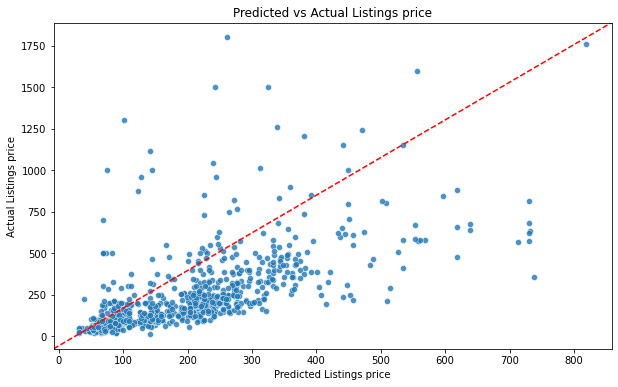

In [127]:
# Plot predicted vs actual values
plt.figure(figsize = (10,6))
sns.scatterplot(np.exp(model_pred_test), np.exp(y_test), alpha = 0.8)
plt.plot([0,1],[0,1], transform = plt.gca().transAxes, ls = "--", c = "red")
plt.xlabel("Predicted Listings price")
plt.ylabel("Actual Listings price")
plt.title("Predicted vs Actual Listings price")
plt.show()

### Interpretability of Model using SHapley Additive exPlanations

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. \
It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [34]:
import shap

explainer = shap.KernelExplainer(model)
shap_values = explainer(X_test)

TypeError: __init__() missing 1 required positional argument: 'data'


1) Global interpretability

    The collective SHAP values shows how much each predictor contributes to the target variable.

    1.1 Variable importance plot \
    1.2 Beeswarm plot

2) Local interpretability

    Traditional variable importance algorithms only show the results across the entire population but not on each individual case. However for SHAP, each observation gets its own set of SHAP values.
    This allows us to be able to explain the prediction of its observation and the contribution of each predictors.

    2.1 Force plot \
    2.2 Waterfall plot \
    2.3 Variance importance plot 

#### Global Interpretability
##### Variable Importance plot

  The Variance importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. 

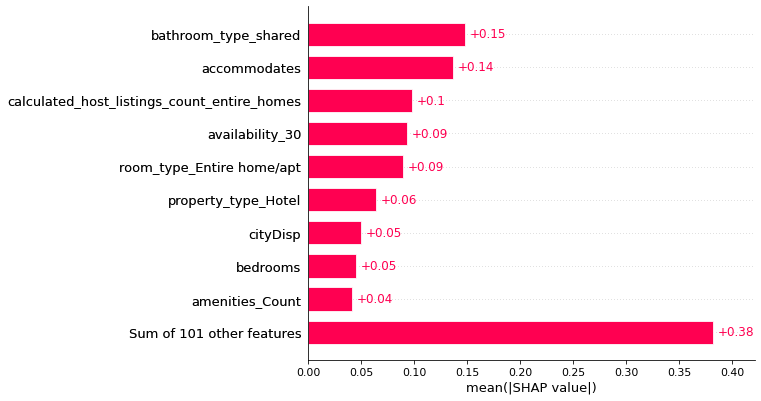

In [256]:
shap.plots.bar(shap_values, max_display=10) # default is max_display=12

##### Beeswarm plot

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. \
Each instance is represented by a single dot on each feature. The horizontal position of the dot is determined by the SHAP value

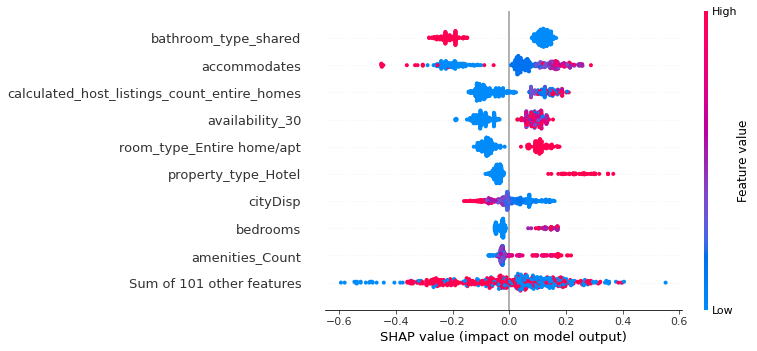

In [257]:
shap.plots.beeswarm(shap_values)

#### Local Interpretability

##### Force plot for a single prediction

Force plot allow us to see how each features contributed to the model prediction, showing each features value for the particular observation.

To demonstrate local interpretability, we will focus on the first 2 observations in the test set.

In [258]:
X_test.head(2)

,name_len,desc_len,mrtDisp,cityDisp,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,availability_30,availability_90,availability_365,accommodates,bedrooms,beds,amenities_Count,instant_bookable,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Ang Mo Kio,neighbourhood_Bedok,neighbourhood_Bishan,neighbourhood_Bukit Batok,neighbourhood_Bukit Merah,neighbourhood_Bukit Panjang,neighbourhood_Bukit Timah,neighbourhood_Central Water Catchment,neighbourhood_Choa Chu Kang,neighbourhood_Clementi,neighbourhood_Downtown Core,neighbourhood_Geylang,neighbourhood_Hougang,neighbourhood_Jurong East,neighbourhood_Jurong West,neighbourhood_Kallang,neighbourhood_Mandai,neighbourhood_Marina South,neighbourhood_Marine Parade,neighbourhood_Museum,neighbourhood_Newton,neighbourhood_Novena,neighbourhood_Orchard,neighbourhood_Outram,neighbourhood_Pasir Ris,neighbourhood_Punggol,neighbourhood_Queenstown,neighbourhood_River Valley,neighbourhood_Rochor,neighbourhood_Sembawang,neighbourhood_Sengkang,neighbourhood_Serangoon,neighbourhood_Singapore River,neighbourhood_Southern Islands,neighbourhood_Tampines,neighbourhood_Tanglin,neighbourhood_Toa Payoh,neighbourhood_Western Water Catchment,neighbourhood_Woodlands,neighbourhood_Yishun,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,property_type_Apartment,property_type_Condominium,property_type_Home,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Others,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_qty_0,bathroom_qty_1,bathroom_qty_10,bathroom_qty_13,bathroom_qty_16,bathroom_qty_2,bathroom_qty_3,bathroom_qty_4,bathroom_qty_5,bathroom_qty_6,bathroom_qty_7,bathroom_qty_8,bathroom_qty_9,bathroom_qty_Private,bathroom_qty_Shared,bathroom_type_bath,bathroom_type_baths,bathroom_type_half-bath,bathroom_type_private,bathroom_type_shared
1138,-0.279783,0.098857,-0.337230,-0.810382,0.135154,-1.556124,0,1,1,0.987989,0.761111,0.767532,1.369404,3.561841,0.898555,1.948535,0,-0.433241,-0.363234,0.603552,0.642478,0.776007,0.501144,0.493591,0.64128,-0.668065,3.662940,3.880655,0.153649,-0.283416,-0.490321,-0.441147,1.772532,-0.697823,-0.070977,-0.206598,-0.087039,-0.076696,-0.249222,-0.064766,-0.096306,-0.028916,-0.076696,-0.127,-0.285133,-0.251108,-0.082026,-0.12356,-0.149008,-0.427559,0.0,-0.04091,-0.112651,-0.076696,-0.104784,-0.241569,-0.139968,-0.330697,-0.070977,-0.076696,-0.23767,-0.217357,-0.318113,-0.108786,-0.050125,-0.100631,6.346327,-0.082026,-0.108786,-0.136833,-0.076696,-0.028916,-0.108786,-0.070977,0.478490,-0.247326,-0.173553,-0.17609,-0.272958,-1.090092,2.376973,-0.372713,-0.249222,-0.372713,-0.04091,-0.050125,1.357656,-0.272958,-1.079146,-0.206598,-0.170982,-1.211628,-0.04091,-0.04091,-0.04091,1.971222,-0.313313,-0.160334,-0.139968,-0.087039,-0.070977,-0.082026,-0.050125,-0.057904,-0.091786,-0.609208,2.017928,-0.108786,-0.521585,-0.664958
1328,0.603859,-0.332266,-0.322682,0.761837,0.505278,0.441776,1,1,1,-0.993220,-1.105576,0.314718,-0.323960,-0.367674,-0.356975,-0.770241,0,-0.329952,-0.353191,0.603552,0.347339,0.476800,0.501144,0.181401,0.64128,0.534043,0.043122,-0.124114,0.347329,-0.283416,-0.490321,-0.441147,-0.564165,1.433029,-0.070977,4.840307,-0.087039,-0.076696,-0.249222,-0.064766,-0.096306,-0.028916,-0.076696,-0.127,-0.285133,-0.251108,-0.082026,-0.12356,-0.14900

In [259]:
# Let us see the value for the 'bedrooms' feature for the first observation
X_test.iloc[0,:]['accommodates']

1.3694035144023198

In [260]:
# Let us see the value for the 'bedrooms' feature for the second observation
X_test.iloc[1,:]['accommodates']

-0.3239601289236894

In [261]:
# We will plot the force plot for the first observation
init.js()
shap.plots.force(shap_values[0])

In [262]:
# We will plot the force plot for the second observation

shap.plots.force(shap_values[0])

In [220]:
# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# def p(j):
#     return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:]))
# p(0)

In [221]:
# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# def p(j):
#     return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:]))
# p(1)

The force plot mainly consists of a base value, output value [f(x)], and the various features (red, blue)
- Base value: This is the value that will be predicted if we do not know of any features for the observation. This will be the mean price (146.2) of all the listings in the test data
- Output value: The prediction for the observation (207.43)
- Red/blue: Features that push the prediction higher to the right (red) or lower to the left (blue)

##### Decision plot for a single prediction

Decision plots allow us to understand how does the complex model arrive at their predictions with how each features affect the Airbnb listings price.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


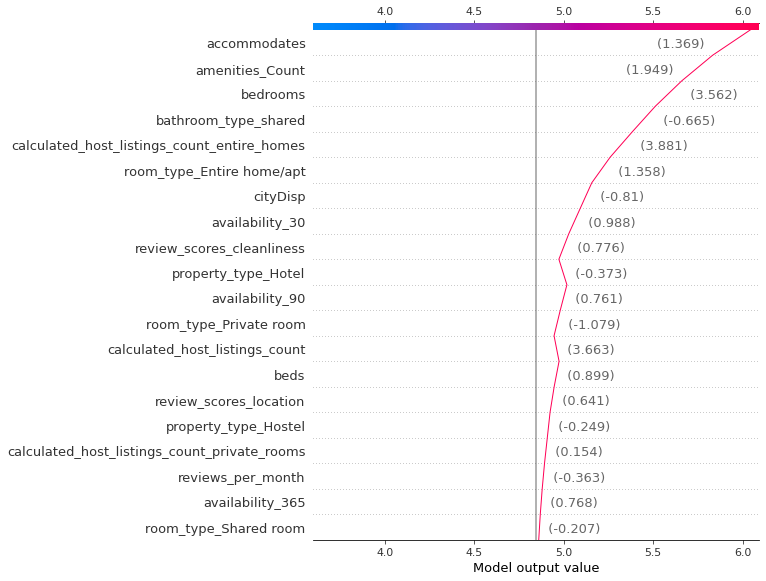

The expected value is  4.8439116
Airbnb listing price for the first observation is  754.0000000000001


In [275]:
# Plot a decision plot
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values, X_test)

print("The expected value is ", expected_value)
print("Airbnb listing price for the first observation is ", np.exp(y_test.iloc[0]))

In [276]:
final_pred_price = round((np.exp(expected_value)),2)

In [277]:
final_pred_price

126.97

In [271]:
expected_value

4.7292557

In [270]:
# Plot SHAP decision plot
shap.decision_plot(expected_value, shap_values, features_display)

NameError: name 'features_display' is not defined

##### Waterfall plot for a single prediction

A waterfall plot powerfully shows why a case receives its prediction given its variable values. You start with the bottom of a waterfall plot and add (red) or subtract (blue) the values to get to the final prediction.
For this project, it shows how each features affect the price of each listings in dollar value, i.e if a listing is an entire home/apt, it will increase the predicted price of the listing by $49.69.

In [264]:
shap_values.shape

(514, 110)

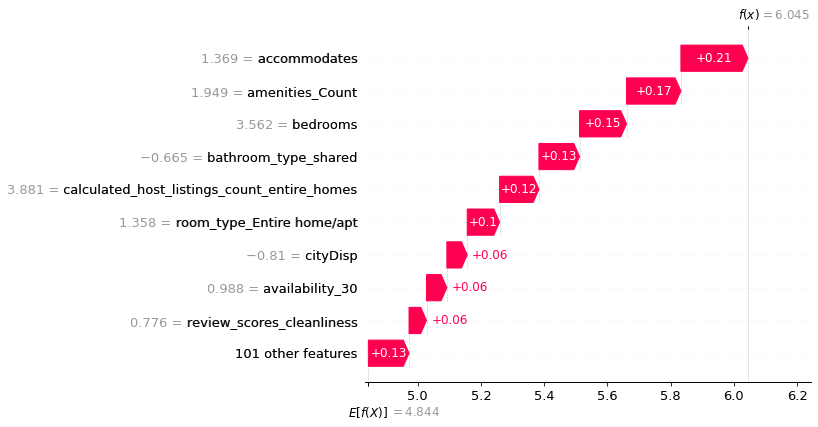

In [265]:
# For the first observation
# Create a waterfall plot
shap.plots.waterfall(shap_values[0])

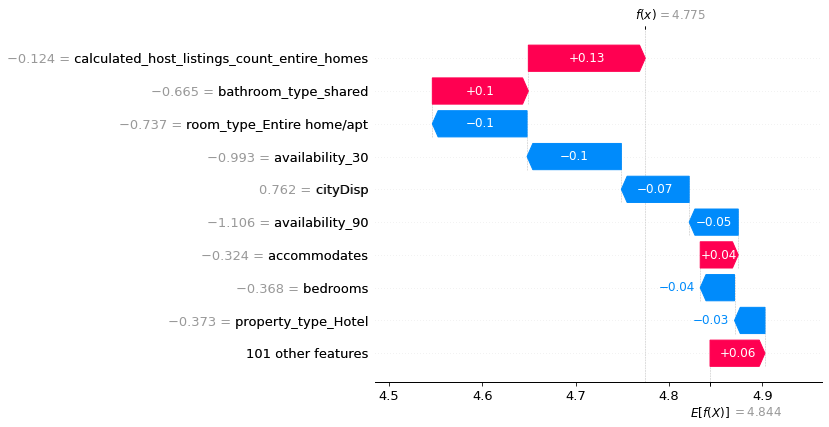

In [263]:
# For the second observation
shap.plots.waterfall(shap_values[1])

##### Variance Importance Plot (Bar plot)

We can also use a bar plot to visualise the contribution of each feature

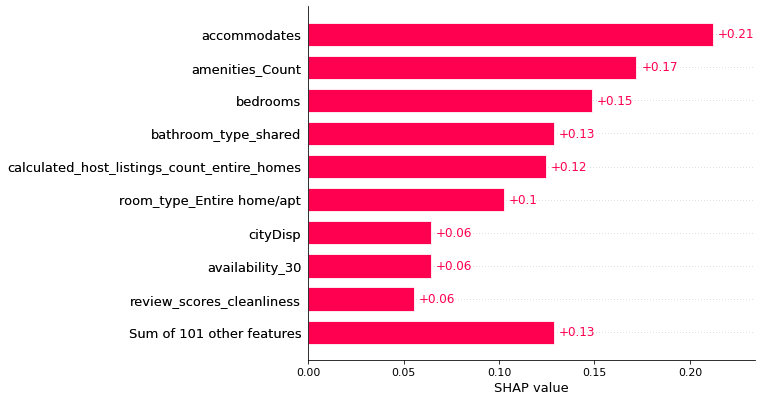

In [266]:
# For the first observation
shap.plots.bar(shap_values[0])

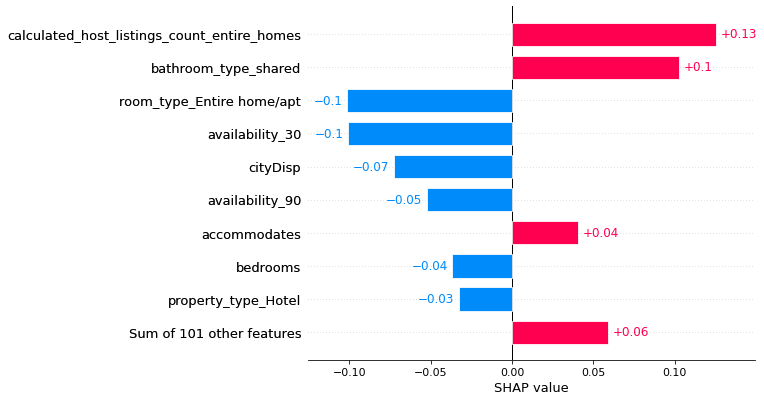

In [267]:
# For the second observation
shap.plots.bar(shap_values[1])